##install necessary libraries

When using ir_explain these libraries are to be installed from the requirements.txt file

In [ ]:
!pip install pyserini==0.25.0
!pip install faiss-cpu
!pip install lime
!pip install beir
!pip install --upgrade ir_datasets


Importing the required scripts in Google Colab

In [2]:
import sys
sys.path.append('/content/')

In [5]:
from PerturbDocument import PerturbDocument
from Pointwise import Pointwise
from EXS import ExplainableSearch
from Lirme import Lirme

from utilities import *

In [6]:
import numpy as np

import lime
from lime import lime_ranker

Initialize the index path if one exists.

In this demo we are using pre-built indices.

In [7]:
index_path = '/path/to/index/'

##retrieve & rerank

Modern Neural Information Retrieval involves a twostage
pipeline. First, given the query 𝑄, a sparse retrieval model
(such as BM25) is used as an initial ranker (𝑀1) to retrieve top 𝑘
documents.
In the second stage (𝑀2), dense retrieval techniques (neural models) are employed to re-rank the set of 𝑘 initially
retrieved documents.

###sparse retrieval

We use the **pyserini** module to perform sparse retrieval
The pyserini searcher can be initialized by mentioned the path of the indexed corpus
Alternately, pyserini provides a function *'from_prebuilt_index()'* to use already indexed corpuses.

In general the searcher can be initialized by specifying the path of the index.

Here we make use of the **"msmarco-v1-passage-full"** index

In [ ]:
from pyserini.search.lucene import LuceneSearcher
#searcher = LuceneSearcher(index_path)
searcher = LuceneSearcher.from_prebuilt_index("msmarco-v1-passage-full")

query = 'what is the daily life of thai people'
retrieved_dict = get_results_from_index(query, searcher, num_docs=10)

doc_ids = retrieved_dict["doc_ids"]
docs = retrieved_dict["docs"]

###Load a reranking model

In the second stage of modern Neural IR, dense
retrieval techniques are employed to re-rank the set of 𝑘 initially
retrieved documents.

We use the beir module to import a reranker.

Here we use the cross-encoder/ms-marco-electra-base model to rerank the initial k retrieved documents

In [ ]:
# Load a reranking model
from beir.reranking.models import CrossEncoder
model = 'cross-encoder/ms-marco-electra-base'
reranker = CrossEncoder(model)

In [10]:
#Rerank using the Neural model
rerank_scores = reranker.predict(list(zip([query]*len(doc_ids),docs)), batch_size=10)
retrieved_dict["rerank_scores"] = rerank_scores

print(rerank_scores)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[9.7950649e-01 1.9957281e-05 2.2687234e-05 9.8405325e-01 9.8600733e-01
 3.4078919e-05 4.0367933e-04 5.9412556e-05 3.2782515e-05 5.1955093e-04]


##EXS explanation

This section generates post-hoc explanation based on the EXS method

Given a list of reranked documents, we specify the rank of the document which we want to explain.
Taking the scores of the reranked documents, the EXS method generates an explanation for the score given by the reranker to this particular document.

In [11]:
explainer = ExplainableSearch(reranker, 'svm', 100)

rank = 2
docids_reranked = retrieved_dict["doc_ids"][np.argsort(retrieved_dict["rerank_scores"])[::-1]]  # descending order.
doc_id_at_r = docids_reranked[rank-1]
doc_at_r = retrieved_dict["docs"][np.argsort(retrieved_dict["rerank_scores"])][-rank]

print("docids_reranked:",docids_reranked)
print("doc_id at r:",doc_id_at_r)
print("doc at r:",doc_at_r)

docids_reranked: ['8139255' '8139258' '8139256' '6164791' '90432' '2735215' '2096427'
 '6016292' '6740558' '2096429']
doc_id at r: 8139258
doc at r: {   "id" : "8139258",   "contents" : "T he following concepts are part of Thai everyday life: à¹à¸à¹à¸¢à¹à¸ or JAI YEN is more a way of life, it is to keep your temper whatever the situation. T hai people are educated in the family and in school to keep frustration inside. Instead of showing their anger toward a problem or situation, Thai people show JAI YEN, i.e. calm or patience." }


###Generate the explantion using the EXS class and visualize the generated term-vector

The red terms in the visualization are terms which have negative influence on the score, while the green terms positively affect the score of the document, as per the explantion generated.

The width of the bars correspond to the magnitude of each term's importance(negative or positive as the case may be)

Inside def explain, scores_topk:
 [0.98600733, 0.98405325]


99it [00:00, 2420.55it/s]


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

lables_perturb unique:  [0 1]
Inside def explain_single, self.exs_model:  svm


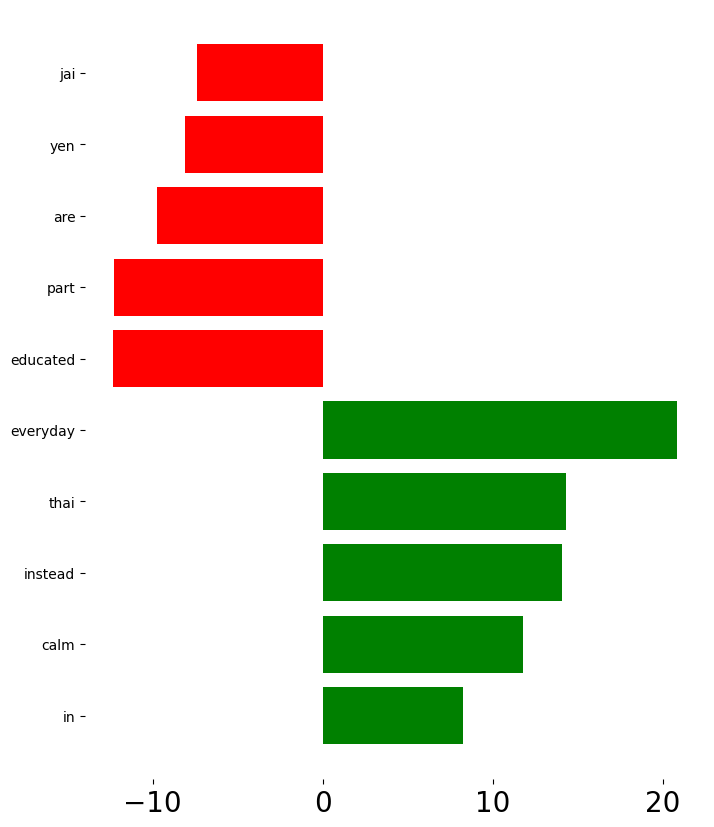

In [34]:
results = explainer.explain(query, retrieved_dict["doc_ids"], retrieved_dict["rerank_scores"], rank, doc_at_r, 'topk-bin')
explainer.visualize(list(zip(results[query][0], results[query][1][0])), saveto = "explanation_exs.pdf", show_top=5)


###remove stopwords
Some of the explanation terms are stopwords, which in reality should not contribute to the explanation of the document.
We can remove these words from the explanation to focus only on the important words in the document

In [13]:
results_no_stopword = explainer.remove_stopwords_from_explanation(results, stopword_file_path = "/content/stop.txt")

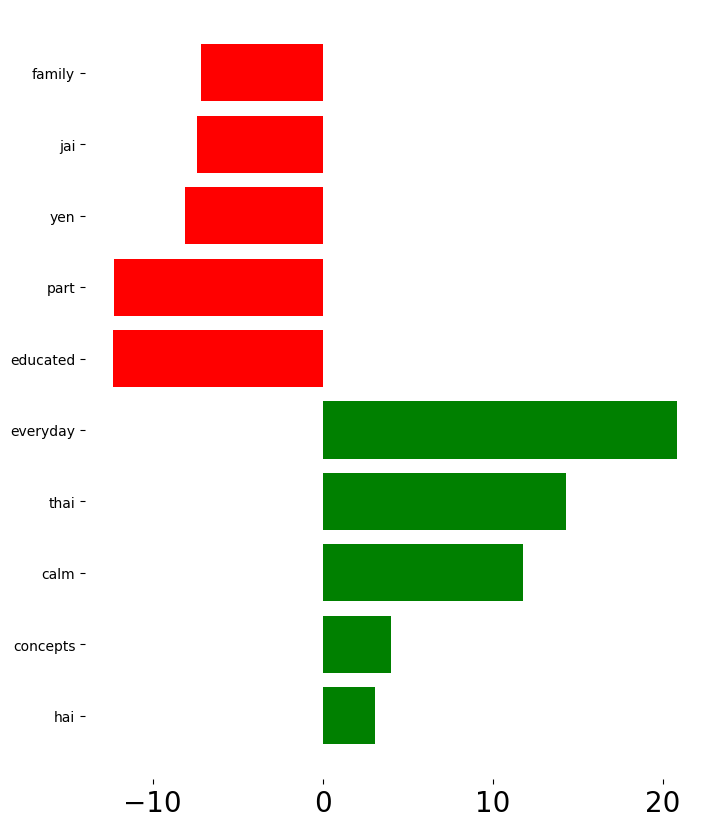

In [14]:
explainer.visualize(list(zip(results_no_stopword[query][0], results_no_stopword[query][1])), saveto = "explanation_no_stopword.pdf", show_top=5)

##LIRME

This section generates post-hoc explanation based on the LIRME methodology

Given a query, document and the score given to this document by the neural reranker, we want to explain why such a score was given by the reranker.

In [15]:
from pyserini.index.lucene import IndexReader

In [16]:
query = 'what is the daily life of thai people'

doc_id = '8139255'
doc_score = 0.98600733

In [17]:
params = {
    "sampling_method" : "masking",
    "top_terms" : 20,
    "kernel_range" : [5,10]

}

Initialize the lirme explainer using the index_path

**Note**: For the demo we are using hardcoded msmarco-passage-full index

In [18]:
lirme = Lirme(index_path)

index_reader :  <pyserini.index.lucene._base.IndexReader object at 0x7df55631b010>


###generate explantion using Lirme class

In [19]:
explanation_vectors, ranked_lists = lirme.explain(query, doc_id, doc_score, reranker, params)

len(samples_generated) :  200
example sample:
 ["{ `` id '' : `` 8139255 '' , `` contents '' : `` An important thing in everyday life is SANUK . Thai people love to have fun together . SANUK can represent many things : eat together , to be with friends and chat , to go out with friends . For Thai people SANUK happens with several persons . '' }"]


Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Document score 0.98600733


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


###Visualize the generated term-vector explanation

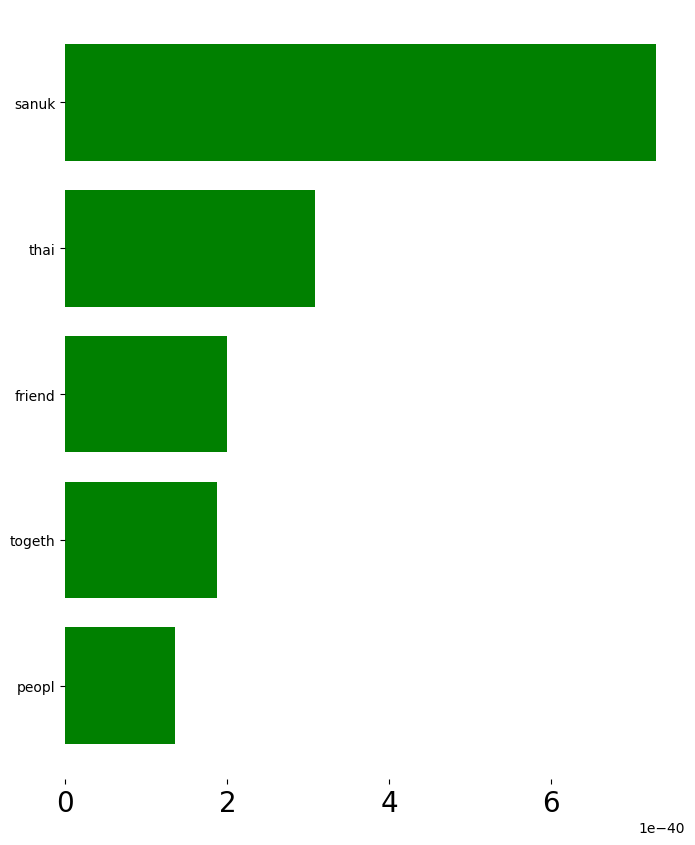

In [20]:
lirme.visualize(explanation_vectors[0]["term_vector"], show_top = 5, show_pos_only=True)

###Evaluation:

The framework also offers two methods to evaluate the explanations generated:

**Consistency and Correctness:**

**Consistency**: By varying the parameters for the functions (such as num_perturbed_samples) multiple explanations for the same query-doc pair can be generated. Consistency is a measure of how similar these explanations are

**Correctness**:
For benchmark datasets, given a query, we can retrive the documents marked relevant for this query.
Using these relevant docs, we can create a term-vector based on the most frequent words in these docs. It is reasonable to assume these words are relevant to the given query.
Correctness measures the similarity between the term-vector generated as the explanation and the term-vector obtained using the relevant documents.

First find relevant documents for the query

In [23]:
query_id='1112341'
rel_docs_list = lirme.find_relevant_docs(query_id)

print(rel_docs_list)

[INFO] Please confirm you agree to the MSMARCO data usage agreement found at <http://www.msmarco.org/dataset.aspx>
[INFO] [starting] https://raw.githubusercontent.com/grill-lab/DL-Hard/main/dataset/dl_hard-passage.qrels
[INFO] [finished] https://raw.githubusercontent.com/grill-lab/DL-Hard/main/dataset/dl_hard-passage.qrels: [00:00] [83.4kB] [31.3MB/s]


TrecQrel(query_id='1112341', doc_id='1369480', relevance=1, iteration='Q0')
TrecQrel(query_id='1112341', doc_id='1373646', relevance=1, iteration='Q0')
TrecQrel(query_id='1112341', doc_id='1373648', relevance=1, iteration='Q0')
TrecQrel(query_id='1112341', doc_id='1707321', relevance=1, iteration='Q0')
TrecQrel(query_id='1112341', doc_id='2173822', relevance=1, iteration='Q0')
TrecQrel(query_id='1112341', doc_id='2468293', relevance=1, iteration='Q0')
TrecQrel(query_id='1112341', doc_id='2468300', relevance=1, iteration='Q0')
TrecQrel(query_id='1112341', doc_id='2596431', relevance=1, iteration='Q0')
TrecQrel(query_id='1112341', doc_id='263958', relevance=1, iteration='Q0')
TrecQrel(query_id='1112341', doc_id='2694630', relevance=1, iteration='Q0')
['1369480', '1373646', '1373648', '1707321', '2173822', '2468293', '2468300', '2596431', '263958', '2694630']


###Now compute the term-vector from the relevant docs

In [ ]:
relevant_doc_vector = lirme.generate_ground_truth_terms(rel_docs_list)

#print(relevant_doc_vector)

In [ ]:
relevant_doc_vector

Compute correctness as:
1. the entropy between the two term-vectors. We call this pe.

2. The cosine similarity between the two term-vectors. We call this cpe.


In [26]:
lirme.correctness(doc_id, explanation_vectors[0]["term_vector"], relevant_doc_vector)

pe, cpe :  5.32900425404719 [[0.2448235]]


(5.32900425404719, array([[0.2448235]]))